# **K-means, E-M  algorithm and SOM**
Quistian Navarro Juan Luis \
341807 \
Ing. Sistemas Inteligentes, Gen 2021 \
Machine Learning, Group 281601

### may/05/24

## **Introduction**

Clustering is a fundamental unsupervised learning technique used to discover patterns and structure within data. It involves grouping similar data points into clusters, where points within the same cluster are more similar to each other than to those in other clusters. In this notebook, we explore the performance of three popular clustering algorithms: k-means, the Expectation-Maximization (E-M) algorithm with Gaussian Mixture Models (GMM) and Self Organising maps (SOM).

We will begin by generating synthetic datasets with different characteristics, such as isotropic blobs, anisotropic blobs, blobs with unequal variance, and unevenly sized blobs. Then, we will apply both k-means, the E-M algorithm and SOM to these datasets and compare their clustering results. Finally, we will conclude by discussing the strengths and limitations of each algorithm and summarizing our findings.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from minisom import MiniSom

In [19]:
# Generate data
n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

# Generate isotropic blobs
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Generate anisotropic blobs
X_aniso = np.dot(X, transformation)  # Anisotropic blobs

# Generate blobs with unequal variance
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance

# Generate unevenly sized blobs
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

In [20]:
# Function to run k-means on the data
def run_kmeans(X):
    kmeans = KMeans(n_clusters=3, random_state=random_state)
    y_pred = kmeans.fit_predict(X)
    return y_pred, kmeans.cluster_centers_

# Function to run E-M algorithm (Gaussian Mixture Model) on the data
def run_em(X):
    gmm = GaussianMixture(n_components=3, random_state=random_state)
    gmm.fit(X)
    y_pred = gmm.predict(X)
    return y_pred, gmm.means_

# Function to run SOM on the data
def run_som(X):
    som_shape = (1, 3)
    som = MiniSom(som_shape[0], 
                  som_shape[1], 
                  X.shape[1], 
                  sigma=.5, 
                  learning_rate=.1,
                  neighborhood_function='gaussian', 
                  random_seed=10)
    
    som.train_batch(X, 500, verbose=False)
    # each neuron represents a cluster
    winner_coordinates = np.array([som.winner(x_) for x_ in X]).T
    # with np.ravel_multi_index we convert the bidimensional
    # coordinates to a monodimensional index
    cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

    centers = som.get_weights()
    return cluster_index, centers
    
# ignore this function
def generate_colors(num_colors):
    colors = plt.cm.tab10(np.linspace(0, 1, num_colors))
    return colors

# Function to plot clustering results
def plot_results(X, y_pred, centers = None, title  = '', colors = None):
    if colors is None:
        colors = generate_colors(len(np.unique(y_pred)))
    plt.scatter(X[:, 0], X[:, 1], c=[colors[i] for i in y_pred])
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, c='red', label='Centroids')
        plt.legend()
    plt.title(title)

# Function to plot som results (is strange)
def plot_som(X, cluster_index, centers, title = '', colors = None):
    if colors is None:
        colors = generate_colors(len(np.unique(cluster_index)))
    for i, cin in enumerate(np.unique(cluster_index)):
        plt.scatter(X[cluster_index == cin, 0], X[cluster_index == cin, 1],  c=[colors[i]])

    # plotting centroids
    for centroid in centers:
        plt.scatter(centroid[:, 0], centroid[:, 1], marker='*', 
                    s=200, c = 'red', label='Centroids')
        plt.legend()

    plt.title(title)

In [21]:
from sklearn import metrics

# Function to evaluate clustering algorithms
def evaluate_clustering(X, y_true, y_pred):
    # Rand
    rand = metrics.adjusted_rand_score(y_true, y_pred)

    # mutual info
    mutual_info = metrics.adjusted_mutual_info_score(y_true, y_pred)
    
    #homogeneity
    homogeneity = metrics.homogeneity_score(y_true, y_pred)

    # completeness
    completeness = metrics.completeness_score(y_true, y_pred)
    # v_measure
    v_measure = metrics.v_measure_score(y_true, y_pred)
    
    #fowlkes_mallows
    fowlkes_mallows = metrics.fowlkes_mallows_score(y_true, y_pred)
    
    return rand, mutual_info, homogeneity, completeness, v_measure, fowlkes_mallows

In [22]:
colors_plot = generate_colors(3)

Dataset: Isotropic Blobs


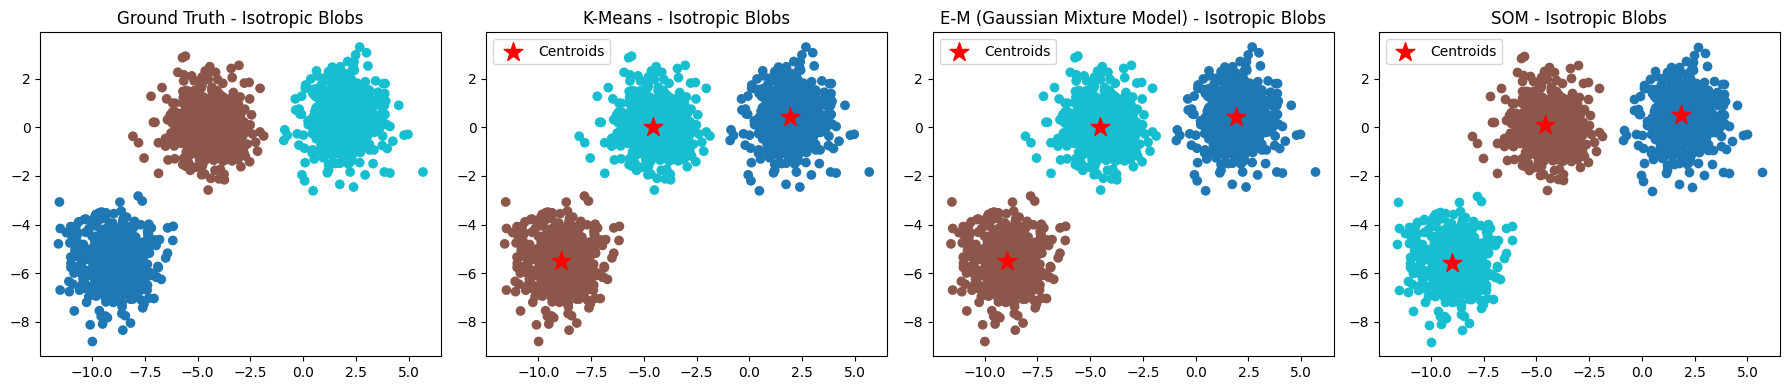

,Method,Adjusted Rand Index,Adjusted Mutual Info,Homogeneity,Completeness,V Measure,Fowlkes-Mallows
0,KMeans,1.0,1.0,1.0,1.0,1.0,1.0
1,EM,1.0,1.0,1.0,1.0,1.0,1.0
2,SOM,1.0,1.0,1.0,1.0,1.0,1.0


Dataset: Anisotropic Blobs


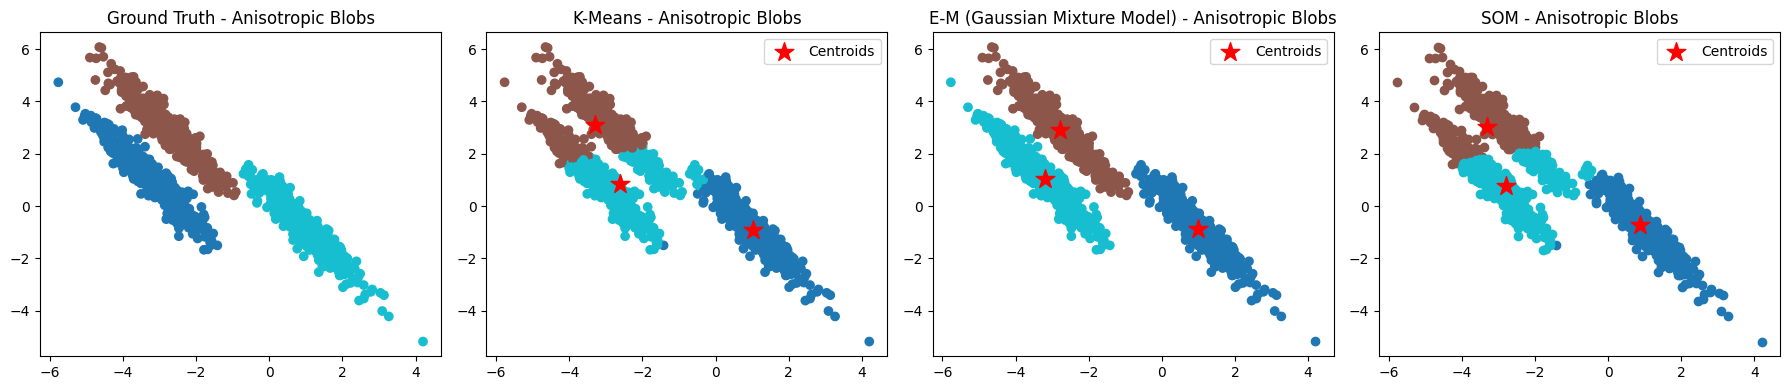

,Method,Adjusted Rand Index,Adjusted Mutual Info,Homogeneity,Completeness,V Measure,Fowlkes-Mallows
0,KMeans,0.612730,0.628622,0.629037,0.629111,0.629074,0.741665
1,EM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,SOM,0.631464,0.645689,0.646054,0.646186,0.646120,0.754173


Dataset: Unequal Variance


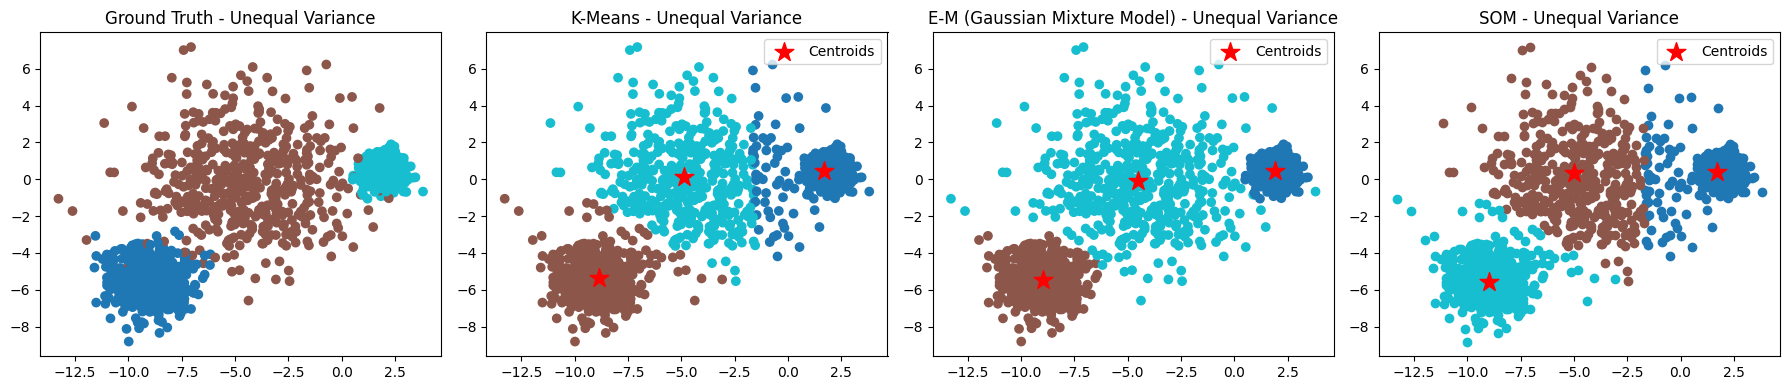

,Method,Adjusted Rand Index,Adjusted Mutual Info,Homogeneity,Completeness,V Measure,Fowlkes-Mallows
0,KMeans,0.829802,0.815216,0.812059,0.818853,0.815442,0.886991
1,EM,0.966394,0.942095,0.942154,0.942176,0.942165,0.977581
2,SOM,0.818244,0.806645,0.802957,0.810845,0.806882,0.879416


Dataset: Unevenly Sized Blobs


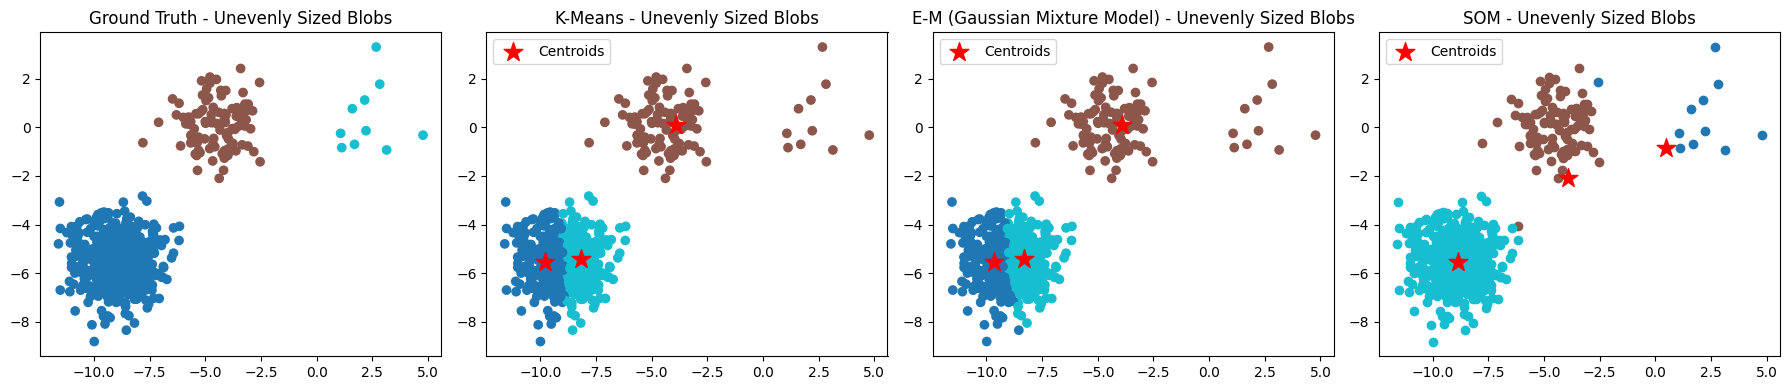

,Method,Adjusted Rand Index,Adjusted Mutual Info,Homogeneity,Completeness,V Measure,Fowlkes-Mallows
0,KMeans,0.382129,0.600809,0.895726,0.454008,0.602588,0.715166
1,EM,0.385290,0.601896,0.895726,0.455242,0.603674,0.717473
2,SOM,0.990985,0.966128,0.972146,0.960600,0.966339,0.997272


In [23]:
import pandas as pd
# Run and compare k-means and E-M for each dataset
datasets = [(X,y, "Isotropic Blobs"), (X_aniso,y, "Anisotropic Blobs"), (X_varied,y_varied, "Unequal Variance"), (X_filtered,y_filtered, "Unevenly Sized Blobs")]

# Create an empty list to store results
all_results = []

# run and plot results
for dataset,y_, title in datasets:
    print("=" * 110)
    print(f"Dataset: {title}")
    print("=" * 110)
    
    # Run k-means
    kmeans_pred, kmeans_centers = run_kmeans(dataset)
    
    # Run E-M
    em_pred, em_centers = run_em(dataset)

    #Run Som
    som_pred, som_centers = run_som(dataset)
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

    # Plot gorund-truth
    plt.sca(axes[0])
    plot_results(dataset, y_, title= "Ground Truth - " + title)

    # Plot k-means results
    plt.sca(axes[1])
    plot_results(dataset, kmeans_pred, kmeans_centers, title= "K-Means - " + title, colors = colors_plot)

    # Plot E-M results
    plt.sca(axes[2])
    plot_results(dataset, em_pred, em_centers, title="E-M (Gaussian Mixture Model) - " + title, colors = colors_plot)
    
    # #Plot som
    plt.sca(axes[3])
    plot_som(dataset, som_pred, som_centers, title="SOM - " + title, colors = colors_plot)

    plt.tight_layout()
    plt.show()
    
    # evlaute perfomance 
    rand_kmeans, mutual_info_kmeans, homogeneity_kmeans, completeness_kmeans, v_measure_kmeans, fowlkes_mallows_kmeans = evaluate_clustering(dataset, y_, kmeans_pred)

    rand_em, mutual_info_em, homogeneity_em, completeness_em, v_measure_em, fowlkes_mallows_em = evaluate_clustering(dataset, y_, em_pred )

    rand_som, mutual_info_som, homogeneity_som, completeness_som, v_measure_som, fowlkes_mallows_som = evaluate_clustering(dataset, y_, som_pred)
    
    # Store results in a DataFrame
    results_df = pd.DataFrame({
        'Method': ['KMeans', 'EM', 'SOM'],
        'Adjusted Rand Index': [rand_kmeans, rand_em, rand_som],
        'Adjusted Mutual Info': [mutual_info_kmeans, mutual_info_em, mutual_info_som],
        'Homogeneity': [homogeneity_kmeans, homogeneity_em, homogeneity_som],
        'Completeness': [completeness_kmeans, completeness_em, completeness_som],
        'V Measure': [v_measure_kmeans, v_measure_em, v_measure_som],
        'Fowlkes-Mallows': [fowlkes_mallows_kmeans, fowlkes_mallows_em, fowlkes_mallows_som]
    })

    display(results_df)
    # Append results to the list
    all_results.append(results_df)
    


final_results_df = pd.concat(all_results, keys=[dataset[2] for dataset in datasets], names=['Dataset'])


### **Metrics to evaluate performance**

In [24]:
final_results_df

Method  Adjusted Rand Index  Adjusted Mutual Info  \
Dataset                                                                     
Isotropic Blobs      0  KMeans             1.000000              1.000000   
                     1      EM             1.000000              1.000000   
                     2     SOM             1.000000              1.000000   
Anisotropic Blobs    0  KMeans             0.612730              0.628622   
                     1      EM             1.000000              1.000000   
                     2     SOM             0.631464              0.645689   
Unequal Variance     0  KMeans             0.829802              0.815216   
                     1      EM             0.966394              0.942095   
                     2     SOM             0.818244              0.806645   
Unevenly Sized Blobs 0  KMeans             0.382129              0.600809   
                     1      EM             0.385290              0.601896   
                     2     SOM             0.990985              0.966128   

                        Homogeneity  Completeness  V Measure  Fowlkes-Mallows  
Dataset                                                                        
Isotropic Blobs      0     1.000000      1.000000   1.000000         1.000000  
                     1     1.000000      1.000000   1.000000         1.000000  
                     2     1.000000      1.000000   1.000000         1.000000  
Anisotropic Blobs    0     0.629037      0.629111   0.629074         0.741665  
                     1     1.000000      1.000000   1.000000         1.000000  
                     2     0.646054      0.646186   0.646120         0.754173  
Unequal Variance     0     0.812059      0.818853   0.815442         0.886991  
                     1     0.942154      0.942176   0.942165         0.977581  
                     2     0.802957      0.810845   0.806882         0.879416  
Unevenly Sized Blobs 0     0.895726      0.454008   0.602588         0.715166  
                     1     0.895726      0.455242   0.603674         0.717473  
                     2     0.972146      0.960600   0.966339         0.997272

##### **Isotropic Blobs:**
All algorithms (KMeans, EM and SOM) performed perfectly. This suggests that the algorithms were able to perfectly classify the data in this simple and well-defined data set.

##### **Anisotropic Blobs:**
KMeans performed slightly worse compared to EM and SOM, with lower scores on all metrics evaluated. This could be due to the anisotropic nature of the groups, which may not be well represented by static centroids.

##### **Unequal Variance:**
KMeans performed decently, but slightly inferior to EM and SOM This could be due to the unequal variance of the groups, which is not well handled by KMeans.

##### **Unevenly Sized Blobs:**
KMeans and EM had relatively low scores on all metrics except homogeneity, where they performed well. This could be due to the unevenly distributed nature of the groups. SOM performed almost perfectly on all metrics, suggesting that it was able to effectively handle groups of different sizes.

## **Conclusion**

In this notebook, we have explored the performance of k-means, the E-M algorithm with Gaussian Mixture Models (GMM) and SOM on synthetic datasets with varying characteristics. Through visualizations and analysis, we have observed how each algorithm handles different types of data distributions and cluster shapes.

Overall, k-means tends to perform well on datasets with isotropic clusters of similar sizes and variances. However, it may struggle with datasets containing anisotropic clusters, unequal variances, or unevenly sized clusters. On the other hand, the E-M algorithm with GMM can handle a wider range of data distributions, including those with non-spherical clusters and varying variances.SOM introduces a distinct perspective by leveraging neural network principles to learn the underlying structure of the data.

It is important to note that the choice of clustering algorithm depends on the specific characteristics of the dataset and the goals of the analysis. While k-means is computationally efficient and easy to interpret, the E-M algorithm with GMM offers more flexibility and can capture complex data distributions more accurately. Som offers a advantage in capturing topological relationships within the data, making it particularly suitable for tasks where preserving the spatial arrangement of data points is essential, such as image processing or feature extraction in high-dimensional data.(how the data points are connected to each other in terms of their relative position in space.)

In practice, it is often beneficial to experiment with multiple clustering algorithms and evaluate their performance on the given dataset before making a final decision. By understanding the strengths and limitations of each algorithm, data scientists can make informed choices and derive meaningful insights from their data.


## **References**

scikit learn: Scikit-learn "Demostration of k-means", Phil Roth: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py


scikit learn: Scikit-learn "Gaussian Mixture Model Sine Curve: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_sin.html?highlight=expectation%20maximization%20algorithm

minisom: https://github.com/JustGlowing/minisom

SELF ORGANISING MAPS: INTRODUCTION (yt): https://www.youtube.com/watch?v=0qtvb_Nx2tA&t=8s


